In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from geo_transform.tf_tps import ThinPlateSpline as tps

import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input
from functools import partial
import os

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from utils import tf_session
tf_session.setup_gpus(True, 0.95)

1 Physical GPUs, 1 Logical GPUs


# 1.Data load

In [4]:
from data_loader.dev_dataset import tf_image_process

In [5]:
_datapath = "sample_dataset"
filelist = os.listdir(_datapath)
input_size = (200, 200)

images = []

for f in filelist:
    _path = os.path.join(_datapath, f)
    img = cv2.imread(_path)[:,:,::-1]
    img = cv2.resize(img, input_size, interpolation=cv2.INTER_AREA)
    images.append(img)

images = np.array(images, dtype=np.float32)

In [6]:
tps_random_rate = 0.4
output_size = (200, 200)
map_func = partial(tf_image_process, tps_random_rate=tps_random_rate,
                      output_size=output_size)
ds = tf.data.Dataset.from_tensor_slices(images)
ds = ds.map(map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds = ds.batch(10)

In [7]:
for A, B, p in ds.take(1):
    print(A.shape, B.shape)
    print(p.shape)

(10, 200, 200, 3) (10, 200, 200, 3)
(10, 9, 2)


In [ ]:
plt.imshow(images[1]/255)

In [ ]:
plt.imshow(A[1])

In [ ]:
plt.imshow(B[1])

# 2. Model definition

In [8]:
from models.cnngeo import CNN_geotransform

In [9]:
# (a) feature extraction
vgg16 = tf.keras.applications.VGG16(weights='imagenet', input_shape=(input_size[0], input_size[1], 3), 
                                    include_top=False)
output_layer = vgg16.get_layer("block4_conv3")
output_layer.activation = None
feature_extractor = tf.keras.Model(inputs=vgg16.input, outputs=output_layer.output)

In [10]:
cnngeo = CNN_geotransform(feature_extractor, 18)
geo_parameters, correlations = cnngeo(A, B)

In [11]:
cnngeo.load_weights("cnngeo.h5")

In [ ]:
cnngeo.summary()

In [ ]:
'''
def generate_inlier_mask(moving_vectors, map_size, thresh=30):
    batch_size = len(geo_parameters)
    height, width = map_size
    x_t = tf.tile(tf.reshape(tf.linspace(0.0, width-1.0, width), [1, width]), [height, 1])
    y_t = tf.tile(tf.reshape(tf.linspace(0.0, height-1.0, height), [height, 1]), [1, width])    
    x_t = tf.tile(x_t[tf.newaxis,::], [batch_size, 1, 1]) # [BN, H, W]
    y_t = tf.tile(y_t[tf.newaxis,::], [batch_size, 1, 1]) # [BN, H, W]
    
    control_points = tf.constant([[-1.0, -1.0], [0.0, -1.0], [1.0, -1.0],
                                   [-1.0, 0.0], [0.0, 0.0], [1.0, 0.0],
                                   [-1.0, 1.0], [0.0, 1.0], [1.0, 1.0]], dtype=tf.float32)    
    control_points = tf.tile(control_points[tf.newaxis,::], [batch_size, 1, 1]) # [BN, 9, 2]
    x_p, y_p = tps(control_points, -moving_vectors, (height, width))
    
    x_t, y_t = x_t[:,:,:,tf.newaxis,tf.newaxis], y_t[:,:,:,tf.newaxis,tf.newaxis] #[BN,H,W,1,1]
    x_p, y_p = x_p[:,tf.newaxis,tf.newaxis,:,:], y_p[:,tf.newaxis,tf.newaxis,:,:] #[BN,1,1,H,W]
    # L2 distance of grids of featureA and grids of featureB, transformed by the estimated geometric transformation.
    l2_dist = tf.sqrt(tf.pow(x_t - x_p, 2) + tf.pow(y_t - y_p, 2)) 
    #inlier_mask = l2_dist
    inlier_mask = tf.cond(l2_dist < height/thresh, 1, 0)
    return inlier_mask
'''

In [12]:
import tensorflow_addons as tfa

moving_vectors = tf.constant([[0.3, 0.0], [0.3, 0.0], [0.3, 0.0],
                                   [0.3, 0.0], [0.3, 0.3], [0.3, 0.0],
                                   [0.3, 0.0], [0.3, 0.0], [0.3, 0.0]], dtype=tf.float32) 
geo_parameters = moving_vectors[tf.newaxis,::]
batch_size=len(geo_parameters)

#fake image
x = np.zeros([3,15,15,1], np.float32)
x[0,0,0] = 1
x[1,7,7] = 1
x[2,14,14] = 1

control_points = tf.constant([[-1.0, -1.0], [0.0, -1.0], [1.0, -1.0],
                                   [-1.0, 0.0], [0.0, 0.0], [1.0, 0.0],
                                   [-1.0, 1.0], [0.0, 1.0], [1.0, 1.0]], dtype=tf.float32) 
control_points = tf.tile(control_points[tf.newaxis,::], [3, 1, 1]) # [BN, 9, 2]
geo_parameters = tf.tile(geo_parameters, [3, 1, 1]) # [BN, 9, 2]
x_s, y_s = tps(control_points, -geo_parameters, (15,15))
remaps = tf.stack([x_s, y_s], axis=-1)
sampled_image = tfa.image.resampler(x, remaps)

/usr/local/lib/python3.6/dist-packages/tensorflow_addons/utils/resource_loader.py:103: UserWarning: You are currently using TensorFlow 2.3.0-rc2 and trying to load a custom op (custom_ops/image/_resampler_ops.so).
TensorFlow Addons has compiled its custom ops against TensorFlow 2.2.0, and there are no compatibility guarantees between the two versions. 
This means that you might get segfaults when loading the custom op, or other kind of low-level errors.
 If you do, do not file an issue on Github. This is a known limitation.

It might help you to fallback to pure Python ops with TF_ADDONS_PY_OPS . To do that, see https://github.com/tensorflow/addons#gpucpu-custom-ops 

You can also change the TensorFlow version installed on your system. You would need a TensorFlow version equal to or above 2.2.0 and strictly below 2.3.0.
 Note that nightly versions of TensorFlow, as well as non-pip TensorFlow like `conda install tensorflow` or compiled from source are not supported.

The last solution i

In [ ]:
figure = plt.figure()
figure.add_subplot(131).imshow(x[0,:,:,0])
figure.add_subplot(132).imshow(x[1,:,:,0])
figure.add_subplot(133).imshow(x[2,:,:,0])

In [ ]:
figure = plt.figure()
figure.add_subplot(131).imshow(sampled_image[0,:,:,0])
figure.add_subplot(132).imshow(sampled_image[1,:,:,0])
figure.add_subplot(133).imshow(sampled_image[2,:,:,0])

In [ ]:
figure = plt.figure()
figure.add_subplot(131).imshow(sampled_image[0,:,:,0])
figure.add_subplot(132).imshow(sampled_image[1,:,:,0])
figure.add_subplot(133).imshow(sampled_image[2,:,:,0])

In [ ]:
figure = plt.figure()
figure.add_subplot(131).imshow(sampled_image[0,:,:,0])
figure.add_subplot(132).imshow(sampled_image[1,:,:,0])
figure.add_subplot(133).imshow(sampled_image[2,:,:,0])

In [ ]:
moving_vectors = tf.constant([[0.3, 0.3], [0.3, 0.0], [0.3, 0.0],
                                   [0.3, 0.0], [0.0, 0.3], [0.3, 0.0],
                                   [0.3, 0.0], [0.3, 0.0], [-0.3, 0.0]], dtype=tf.float32) 
geo_parameters = moving_vectors[tf.newaxis,::]
batch_size = 1

height, width = 15, 15
identity_mask = np.zeros((height*width*height*width))
idx_list = list(range(0, height*width*height*width, height*width+1))
identity_mask[idx_list] = 1
identity_mask = np.reshape(identity_mask, (1, height,width,height,width))
    
identity_mask = tf.constant(identity_mask, tf.float32)
identity_mask = tf.tile(identity_mask, [batch_size,1,1,1,1])

#calculate estimated coordinates of source grids on target feature grids
control_points = tf.constant([[-1.0, -1.0], [0.0, -1.0], [1.0, -1.0],
                                   [-1.0, 0.0], [0.0, 0.0], [1.0, 0.0],
                                   [-1.0, 1.0], [0.0, 1.0], [1.0, 1.0]], dtype=tf.float32) 

control_points = tf.tile(control_points[tf.newaxis,::], [batch_size*height*width, 1, 1])
geo_parameters = tf.tile(geo_parameters, [batch_size*height*width, 1, 1])

x_s, y_s = tps(control_points, -geo_parameters, (height,width))
remaps = tf.stack([x_s, y_s], axis=-1)

reshaped_identity_mask = tf.reshape(identity_mask, [batch_size*height*width, height, width, 1])
sampled_image = tfa.image.resampler(reshaped_identity_mask, remaps)
sampled_image = tf.reshape(sampled_image, [batch_size, height,width,height,width])

figure = plt.figure()
figure.add_subplot(231).imshow(identity_mask[0,0,0])
figure.add_subplot(232).imshow(identity_mask[0,7,7])
figure.add_subplot(233).imshow(identity_mask[0,14,14])

figure.add_subplot(234).imshow(sampled_image[0,0,0])
figure.add_subplot(235).imshow(sampled_image[0,7,7])
figure.add_subplot(236).imshow(sampled_image[0,14,14])

In [ ]:
geo_parameters, correlations = cnngeo(A,B)

In [ ]:
geo_parameters.shape

In [ ]:
geo_parameters = tf.concat([geo_parameters, moving_vectors[tf.newaxis,::]], axis=0)
print(geo_parameters.shape)

In [ ]:
batch_size = 11

height, width = 15, 15
identity_mask = np.zeros((height*width*height*width))
idx_list = list(range(0, height*width*height*width, height*width+1))
identity_mask[idx_list] = 1
identity_mask = np.reshape(identity_mask, (1, height,width,height,width))
    
identity_mask = tf.constant(identity_mask, tf.float32)
identity_mask = tf.tile(identity_mask, [batch_size,1,1,1,1])

#calculate estimated coordinates of source grids on target feature grids
control_points = tf.constant([[-1.0, -1.0], [0.0, -1.0], [1.0, -1.0],
                                   [-1.0, 0.0], [0.0, 0.0], [1.0, 0.0],
                                   [-1.0, 1.0], [0.0, 1.0], [1.0, 1.0]], dtype=tf.float32) 

control_points = tf.tile(control_points[tf.newaxis,::], [batch_size*height*width, 1, 1])
geo_parameters = geo_parameters[tf.newaxis,::]
geo_parameters = tf.tile(geo_parameters, [height*width, 1, 1, 1])
geo_parameters = tf.reshape(geo_parameters, [batch_size*height*width,9, 2])

x_s, y_s = tps(control_points, -geo_parameters, (height,width))
remaps = tf.stack([x_s, y_s], axis=-1)

reshaped_identity_mask = tf.reshape(identity_mask, [batch_size*height*width, height, width, 1])
sampled_image = tfa.image.resampler(reshaped_identity_mask, remaps)
sampled_image = tf.reshape(sampled_image, [batch_size, height,width,height,width])

figure = plt.figure()
figure.add_subplot(231).imshow(identity_mask[10,0,0])
figure.add_subplot(232).imshow(identity_mask[10,7,7])
figure.add_subplot(233).imshow(identity_mask[10,14,14])

figure.add_subplot(234).imshow(sampled_image[10,0,0])
figure.add_subplot(235).imshow(sampled_image[10,7,7])
figure.add_subplot(236).imshow(sampled_image[10,14,14])

In [ ]:
geo_parameters, correlations = cnngeo(A,B)
moving_vectors = tf.constant([[0.0, 0.0], [0.0, 0.0], [0.0, 0.0],
                                   [0.0, 0.0], [0.2, 0.2], [0.0, 0.0],
                                   [0.0, 0.0], [0.0, 0.0], [-0.3, 0.0]], dtype=tf.float32) 

geo_parameters = tf.concat([geo_parameters, moving_vectors[tf.newaxis,::]], axis=0)

In [ ]:
geo_parameters.shape

In [ ]:
geo_parameters[10]

In [ ]:
batch_size=len(geo_parameters)

In [ ]:
height, width = 15, 15
identity_mask = np.zeros((height*width*height*width))
idx_list = list(range(0, height*width*height*width, height*width+1))
identity_mask[idx_list] = 1
identity_mask = np.reshape(identity_mask, (1, height,width,height,width))
    
identity_mask = tf.constant(identity_mask, tf.float32)
identity_mask = tf.tile(identity_mask, [batch_size,1,1,1,1])

#calculate estimated coordinates of source grids on target feature grids
control_points = tf.constant([[-1.0, -1.0], [0.0, -1.0], [1.0, -1.0],
                                   [-1.0, 0.0], [0.0, 0.0], [1.0, 0.0],
                                   [-1.0, 1.0], [0.0, 1.0], [1.0, 1.0]], dtype=tf.float32)  

control_points = tf.tile(control_points[tf.newaxis,::], [batch_size, 1, 1]) # [BN, 9, 2]

x_s, y_s = tps(control_points, -geo_parameters, (height,width))
remaps = tf.stack([x_s, y_s], axis=-1)

In [ ]:
remaps.shape

In [ ]:
_identity_mask = tf.reshape(identity_mask, [batch_size*height*width, height, width, 1])

_remaps = tf.tile(remaps[:,tf.newaxis,::], [1,height*width, 1, 1, 1])

print(_identity_mask.shape)
print(_remaps.shape)

In [ ]:
_remaps = tf.reshape(_remaps, [batch_size*height*width,height,width,2])

In [ ]:
converted_mask = tfa.image.resampler(_identity_mask, _remaps)

In [ ]:
inverse_identity_mask = tf.reshape(_identity_mask, [batch_size,height,width,height,width])
inverse_converted_mask = tf.reshape(converted_mask, [batch_size, height, width, height, width])

In [ ]:
figure = plt.figure()
figure.add_subplot(231).imshow(inverse_identity_mask[10,0,0])
figure.add_subplot(232).imshow(inverse_identity_mask[10,7,7])
figure.add_subplot(233).imshow(inverse_identity_mask[10,14,14])
figure.add_subplot(234).imshow(inverse_converted_mask[10,0,0])
figure.add_subplot(235).imshow(inverse_converted_mask[10,7,7])
figure.add_subplot(236).imshow(inverse_converted_mask[10,14,14])


In [13]:
geo_parameters, correlations = cnngeo(A,B)

In [20]:
from scipy.ndimage.morphology import binary_dilation, generate_binary_structure

def generate_inlier_mask(geo_parameters, map_size, thresh=30):
    batch_size=len(geo_parameters)
    height, width = map_size
    identity_mask = np.zeros((height*width*height*width))
    idx_list = list(range(0, height*width*height*width, height*width+1))
    identity_mask[idx_list] = 1
    identity_mask = np.reshape(identity_mask, (height,width,height,width))
    dilation_filter = generate_binary_structure(2, 2)
    for h in range(height):
        for w in range(width):
            identity_mask[h,w] = binary_dilation(identity_mask[h,w], structure=dilation_filter).astype(identity_mask.dtype)
    identity_mask = identity_mask[tf.newaxis,::]
    identity_mask = np.reshape(identity_mask, (1, height,width,height,width))

    identity_mask = tf.constant(identity_mask, tf.float32)
    identity_mask = tf.tile(identity_mask, [batch_size,1,1,1,1]) #[BN,H,W,H,W] of identity matrix
    '''
        We reshape it for convenient parallel processing of remapping.
        Each H*W inlier masks are remaped by the same geometric transformation.
        Therefore, We calculate BN remaps and repeat H*W of it.
    '''
    identity_mask = tf.reshape(identity_mask, [batch_size*height*width, height, width, 1]) #[BN*H*W,H,W,1].

    #calculate estimated coordinates of source grids on target feature grids
    control_points = tf.constant([[-1.0, -1.0], [0.0, -1.0], [1.0, -1.0],
                                       [-1.0, 0.0], [0.0, 0.0], [1.0, 0.0],
                                       [-1.0, 1.0], [0.0, 1.0], [1.0, 1.0]], dtype=tf.float32)  
    control_points = tf.tile(control_points[tf.newaxis,::], [batch_size, 1, 1]) # [BN, 9, 2]
    x_s, y_s = tps(control_points, -geo_parameters, (height,width))
    #calculate BN remaps
    remaps = tf.stack([x_s, y_s], axis=-1) #[BN,H,W,2]
    #repeat each remap H*W times. 
    remaps = tf.tile(remaps[:,tf.newaxis,::], [1,height*width, 1, 1, 1]) #[BN,H*W,H,W,2]
    print(remaps.shape)
    remaps = tf.reshape(remaps, [batch_size*height*width,height,width,2]) #[BN*H*W,H,W,2]

    inlier_masks = tfa.image.resampler(identity_mask, remaps) #inputs <= identity_mask([BN*H*W,H,W,1]) remaps([BN*H*W,H,W,2])
    inlier_masks = tf.reshape(inlier_masks, [batch_size, height, width, height, width]) #reshape again. 
    return inlier_masks #[BN,H,W,H,W]

In [21]:
moving_vectors = tf.constant([[0.0, 0.0], [0.0, 0.0], [0.0, 0.0],
                                   [0.0, 0.0], [0.0, 0.0], [0.0, 0.0],
                                   [0.0, 0.0], [0.0, 0.0], [-0.3, 0.0]], dtype=tf.float32) 
moving_vectors = moving_vectors[tf.newaxis,::]

In [22]:
print(moving_vectors.shape)
inlier_mask = generate_inlier_mask(moving_vectors, (25,25))
print(inlier_mask.shape)


(1, 9, 2)
(1, 625, 25, 25, 2)
(1, 25, 25, 25, 25)


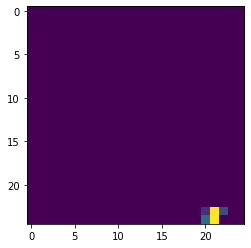

In [29]:
plt.imshow(inlier_mask[0,24,24])

In [ ]:
print(identity_mask.shape)
print(remaps.shape)

In [ ]:
_identity_mask = tf.reshape(identity_mask, [batch_size*height*width, height, width, 1])
_remaps = tf.tile(remaps, [height*width, 1, 1, 1])
print(_identity_mask.shape)
print(_remaps.shape)

In [ ]:
import tensorflow_addons as tfa
sampled_image = tfa.image.resampler(_identity_mask, _remaps)

In [ ]:
sampled_image.shape

In [ ]:
sampled_image = tf.reshape(sampled_image, [batch_size, height, width, height, width])
print(sampled_image.shape)

In [ ]:
plt.imshow(identity_mask[0,:,:,0,0])

In [ ]:
plt.imshow(sampled_image[0,:,:,0,0])

In [ ]:
plt.imshow(identity_mask[0,:,:,1,1])

In [ ]:
plt.imshow(sampled_image[0,:,:,1,1])

In [ ]:
plt.imshow(identity_mask[0,:,:,2,2])

In [ ]:
plt.imshow(sampled_image[0,:,:,2,2])

In [ ]:
sampled_image = tfa.image.resampler(tf.ones([1,8,8,3]), remaps[:1,::])
plt.imshow(sampled_image.numpy()[0])

In [ ]:
x = np.zeros([3,8,8,3], np.float32)

In [ ]:
x[0,0,0] = 1
x[1,1,1] = 1
x[2,2,2] = 1

In [ ]:
plt.imshow(x[0])

In [ ]:
plt.imshow(x[1])

In [ ]:
plt.imshow(x[2])

In [ ]:
sampled_image = tfa.image.resampler(x, remaps[:3,::])

In [ ]:
plt.imshow(sampled_image.numpy()[0])

In [ ]:
plt.imshow(sampled_image.numpy()[1])

In [ ]:
plt.imshow(sampled_image.numpy()[2])

In [ ]:
identity_mask = tf.reshape(identity_mask, [-1, height,width])

In [ ]:
remaps.shape

In [ ]:
identity_mask[0][:,:,0,0]

In [ ]:
identity_mask.shape

In [ ]:
#calculate estimated coordinates of source grids on target feature grids
control_points = tf.constant([[-1.0, -1.0], [0.0, -1.0], [1.0, -1.0],
                                   [-1.0, 0.0], [0.0, 0.0], [1.0, 0.0],
                                   [-1.0, 1.0], [0.0, 1.0], [1.0, 1.0]], dtype=tf.float32)  


moving_vectors = tf.constant([[0.1, 0.0], [0.1, 0.0], [0.1, 0.0],
                                   [0.1, 0.0], [0.1, 0.0], [0.1, 0.0],
                                   [0.1, 0.0], [0.1, 0.0], [0.1, 0.0]], dtype=tf.float32) 

control_points = control_points[tf.newaxis,::]
moving_vectors = moving_vectors[tf.newaxis,::]

x_s, y_s = tps(control_points, -moving_vectors, (200,200))

In [ ]:
x_s.shape, y_s.shape

In [ ]:
img_name = "sample_dataset/060_0000.png"
img = cv2.imread(img_name)[:,:,::-1]
img = cv2.resize(img, (200, 200) ,interpolation=cv2.INTER_AREA)
plt.imshow(img)

In [ ]:
img = img[np.newaxis,::]

In [ ]:
import tensorflow_addons as tfa
s_img = img/255
s_img = s_img.astype(np.float32)
sampled_image = tfa.image.resampler(s_img, tf.stack([x_s, y_s], axis=-1))
plt.imshow(sampled_image[0].numpy())

In [ ]:
def generate_inlier_mask(moving_vectors, map_size, thresh=30):
    batch_size = len(geo_parameters)
    height, width = map_size
    
    #generate identity masks of batch_size
    identity_mask = np.zeros((height*width*height*width))
    idx_list = list(range(0, height*width*height*width, height*width+1))
    identity_mask[idx_list] = 1
    identity_mask = np.reshape(identity_mask, (1, height,width,height,width))
    
    identity_mask = tf.constant(identity_mask, tf.float32)
    identity_mask = tf.tile(identity_mask, [batch_size,1,1,1,1]) #[BN,H,W,H,W]
    
    #calculate estimated coordinates of source grids on target feature grids
    control_points = tf.constant([[-1.0, -1.0], [0.0, -1.0], [1.0, -1.0],
                                   [-1.0, 0.0], [0.0, 0.0], [1.0, 0.0],
                                   [-1.0, 1.0], [0.0, 1.0], [1.0, 1.0]], dtype=tf.float32)  
    control_points = tf.tile(control_points[tf.newaxis,::], [batch_size, 1, 1]) # [BN, 9, 2]
    x_s, y_s = tps(control_points, -moving_vectors, out_size)
    remaps = tf.stack([x_s, y_s], axis=-1)
    
    
    x_t = tf.tile(tf.reshape(tf.linspace(0.0, width-1.0, width), [1, width]), [height, 1])
    y_t = tf.tile(tf.reshape(tf.linspace(0.0, height-1.0, height), [height, 1]), [1, width])    
    x_t = tf.tile(x_t[tf.newaxis,::], [batch_size, 1, 1]) # [BN, H, W]
    y_t = tf.tile(y_t[tf.newaxis,::], [batch_size, 1, 1]) # [BN, H, W]
    
    control_points = tf.constant([[-1.0, -1.0], [0.0, -1.0], [1.0, -1.0],
                                   [-1.0, 0.0], [0.0, 0.0], [1.0, 0.0],
                                   [-1.0, 1.0], [0.0, 1.0], [1.0, 1.0]], dtype=tf.float32)    
    control_points = tf.tile(control_points[tf.newaxis,::], [batch_size, 1, 1]) # [BN, 9, 2]
    x_p, y_p = tps(control_points, -moving_vectors, (height, width))
    
    x_t, y_t = x_t[:,:,:,tf.newaxis,tf.newaxis], y_t[:,:,:,tf.newaxis,tf.newaxis] #[BN,H,W,1,1]
    x_p, y_p = x_p[:,tf.newaxis,tf.newaxis,:,:], y_p[:,tf.newaxis,tf.newaxis,:,:] #[BN,1,1,H,W]
    # L2 distance of grids of featureA and grids of featureB, transformed by the estimated geometric transformation.
    l2_dist = tf.sqrt(tf.pow(x_t - x_p, 2) + tf.pow(y_t - y_p, 2)) 
    #inlier_mask = l2_dist
    inlier_mask = tf.cond(l2_dist < height/thresh, 1, 0)
    return inlier_mask

In [ ]:
mask_id = tf.zeros([4,4,4*4])
idx_list = list(range(0, tf.size(mask_id), mask_id.shape[2]+1))

In [ ]:
tf.reshape(mask_id.reshape((-1))[idx_list]=1

In [ ]:
type(mask_id)

In [ ]:
mask_id.size

In [ ]:
idx_list

In [ ]:
mask_id.shape

In [ ]:
mask_id = np.zeros((w_matches,h_matches,w_matches*h_matches))
idx_list = list(range(0, mask_id.size, mask_id.shape[2]+1))

In [ ]:
mask_id = np.reshape(mask_id, [4,4,4,4])

In [ ]:
mask_id[0,1]

In [ ]:
generate_inlier_mask(geo_parameters, (25, 25))

In [ ]:
cnngeo(A, B)

In [ ]:
class CNN_geotransform(tf.keras.Model):
    def __init__(self, feature_extractor, num_param):
        super(CNN_geotransform, self).__init__()
        self.feature_extractor = feature_extractor
        self.correlation_net = Correlation_network()
        self.regressor = Spatial_regressor(9*2)
    def call(self, imageA, imageB):
        featureA = self.feature_extractor(imageA)
        featureB = self.feature_extractor(imageB)
        featureA = feature_l2_normalization(featureA)
        featureB = feature_l2_normalization(featureB)
        correlations = self.correlation_net(featureA, featureB)
        correlations = tf.keras.layers.Activation("relu")(correlations)
        correlations = normalize_correlation(correlations)
        geo_parameters = self.regressor(correlations)
        return geo_parameters, correlations

In [ ]:
class Correlation_network(tf.keras.layers.Layer):
    def __init__(self):
        super(Correlation_network, self).__init__()

    def call(self, feature_A, feature_B):
        # featureA : feature information from source image
        # featureB : feature information from target image
        #assert feature_A.shape == feature_B.shape
        # new feature A and feature B have new shape of tensors.
        # featureA has tensor shape as [batch, HA, WA, 1, 1, depth]
        # featureB has tensor shape as [batch, 1, 1, HB, WB, depth]
        feature_A = feature_A[:, :, :, tf.newaxis, tf.newaxis, :]
        feature_B = feature_B[:, tf.newaxis, tf.newaxis, :, :, :]
        # correlation score has tensor shape as [batch, HA, WA, HB, WB]
        corr_score = tf.reduce_sum(tf.multiply(feature_A, feature_B), axis=-1)
        return corr_score

In [ ]:
from models.module import feature_l2_normalization, normalize_correlation

class CNN_align(tf.keras.Model):
    def __init__(self, feature_extractor, regressor, thresh=30):
        super(CNN_align, self).__init__()
        self.model_name = 'CNNalign'
        self.feature_extractor = feature_extractor
        self.correlation_net = Correlation_network()
        self.regressor = regressor
        self.thresh = thresh
    def call(self, imageA, imageB):
        featureA = self.feature_extractor(imageA)
        featureB = self.feature_extractor(imageB)
        featureA = feature_l2_normalization(featureA)
        featureB = feature_l2_normalization(featureB)
        correlations = self.correlation_net(featureA, featureB)
        correlations = tf.keras.layers.Activation("relu")(correlations)
        correlations = normalize_correlation(correlations)
        geo_parameters = self.regressor(correlations)        
        
        map_size = correlations.shape[-2:]
        inlier_masks = generate_inlier_mask(geo_parameters, map_size, thresh = self.thresh)
        inlier_matching = correlations * inlier_masks  # B, H, W, H, W
        inlier_count = tf.reduce_sum(inlier_matching, axis=(1, 2, 3, 4))
        return inlier_matching, inlier_count

    def save(self, ckpt_path):
        self.cnn_geo.save(ckpt_path)

    def load(self, ckpt_path):
        self.cnn_geo.load(ckpt_path)

In [ ]:
feature_extractor = cnngeo.feature_extractor
feature_extractor.layers

In [ ]:
regressor = cnngeo.regressor
regressor.layers[0].layers

In [ ]:
cnnalign = CNN_align(feature_extractor, regressor)

In [ ]:
cnnalign(A,B)
cnnalign.summary()

In [ ]:
tf.keras.utils.plot_model(cnnalign)

In [ ]:
cnnalign.cnn_geo.summary()

In [ ]:
cnnalign.cnn_geo.regressor.summary()

In [ ]:
tmp = cnnalign.cnn_geo.regressor.get_weights()

In [ ]:
tmp[0].shape

# 3.Training

In [ ]:
def loss_fn(pred):
    return tf.reduce_mean(-pred)

@tf.function
def train_step(image_A, image_B, label, model, optimizer):
    with tf.GradientTape() as tape:
        inlier_matching, inlier_count = model(image_A, image_B)
        loss = loss_fn(inlier_count)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, gradients

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1E-4)

train_loss = tf.metrics.Mean(name='train_loss')
x_axis = []
y_loss = []
for epoch in range(1):
    for step, (image_a, image_b, labels) in enumerate(ds):
        t_loss, _gradients = train_step(image_a, image_b, labels, cnnalign, optimizer)
        train_loss(t_loss)
    template = 'Epoch {}, Loss: {}'
    print(template.format(epoch + 1, train_loss.result()))
    x_axis.append(epoch)
    y_loss.append(train_loss.result().numpy())
    train_loss.reset_states()

In [ ]:
_gradients

In [ ]:
fig = plt.figure()
axis = fig.add_subplot(111)
axis.title.set_text("training_loss")
axis.set_xlabel("epoch")
axis.set_ylabel("training loss")
axis.plot(np.array(x_axis), np.array(y_loss))

In [ ]:
cnnalign.trainable_variables

In [ ]:
_tmp = cnnalign.cnn_geo.regressor.get_weights()

In [ ]:
for A, B, p in ds.take(1):
    print(A.shape, B.shape)
    preds = cnngeo(A, B)

warping_images = []
output_size = A.shape[1:3]
control_points = tf.constant([[-1.0, -1.0], [0.0, -1.0], [1.0, -1.0],
                               [-1.0, 0.0], [0.0, 0.0], [1.0, 0.0],
                               [-1.0, 1.0], [0.0, 1.0], [1.0, 1.0]], dtype=tf.float32)
for image, pred in zip(A, preds):
    x_s, y_s = tps(control_points[tf.newaxis,::], -pred[tf.newaxis,::], output_size)
    image = image.numpy()
    warping_images.append(cv2.remap(image, x_s[0].numpy(), y_s[0].numpy(), cv2.INTER_CUBIC))

warping_images = np.array(warping_images)    

In [ ]:
def restore_original_image_from_array(x, data_format=None):
    mean = [103.939, 116.779, 123.68]

    # Zero-center by mean pixel
    if data_format == 'channels_first':
        if x.ndim == 3:
            x[0, :, :] += mean[0]
            x[1, :, :] += mean[1]
            x[2, :, :] += mean[2]
        else:
            x[:, 0, :, :] += mean[0]
            x[:, 1, :, :] += mean[1]
            x[:, 2, :, :] += mean[2]
    else:
        x[..., 0] += mean[0]
        x[..., 1] += mean[1]
        x[..., 2] += mean[2]

    if data_format == 'channels_first':
        # 'BGR'->'RGB'
        if x.ndim == 3:
            x = x[::-1, ...]
        else:
            x = x[:, ::-1, ...]
    else:
        # 'BGR'->'RGB'
        x = x[..., ::-1]

    return x

In [ ]:
plt.imshow(A[1])

In [ ]:
plt.imshow(B[1])

In [ ]:
plt.imshow(warping_images[4])

In [ ]:
plt.imshow(restore_original_image_from_array(B[1].numpy())/255)

In [ ]:
plt.imshow(restore_original_image_from_array(warping_images[1])/255)

In [ ]:
plt.imshow(images[1]/255)

# Comparison between ground-truth and prediction of motion vectors.

In [ ]:
print(p.shape)
print(preds.shape)

In [ ]:
for A, B, p in ds.take(1):
    print(A.shape, B.shape)
    preds = cnngeo(A, B)

warping_images = []
output_size = A.shape[1:3]
control_points = tf.constant([[-1.0, -1.0], [0.0, -1.0], [1.0, -1.0],
                               [-1.0, 0.0], [0.0, 0.0], [1.0, 0.0],
                               [-1.0, 1.0], [0.0, 1.0], [1.0, 1.0]], dtype=tf.float32)
for image, pred in zip(A, preds):
    x_s, y_s = tps(control_points[tf.newaxis,::], -pred[tf.newaxis,::], output_size)
    image = image.numpy()
    warping_images.append(cv2.remap(image, x_s[0].numpy(), y_s[0].numpy(), cv2.INTER_CUBIC))

warping_images = np.array(warping_images)    

In [ ]:
from dev_utils import draw
def decode(x):
    x = (x + 1)/2
    if type(x) != np.ndarray:
        return x.numpy()
    else:
        return x
def makeBorder(image, bordersize):
    draw_image = image.copy()
    color = [1, 1, 1]
    draw_image = cv2.copyMakeBorder(draw_image,
                                    top=bordersize, bottom=bordersize,
                                    left=bordersize, right=bordersize,
                                    borderType=cv2.BORDER_CONSTANT,
                                    value=color)
    return draw_image


def draw_point(image, bordersize, points=None):
    draw_image = image.copy()
    H, W, C = draw_image.shape
    if points is None:
        points = np.array([[0.0, 0.0], [0.5, 0.0], [1.0, 0.0],
                           [0.0, 0.5], [0.5, 0.5], [1.0, 0.5],
                           [0.0, 1.0], [0.5, 1.0], [1.0, 1.0]])
    points = points * (W - 2 * bordersize, H - 2 * bordersize)
    points = points.astype(np.int32)
    for pnt in points:
        draw_image = cv2.circle(draw_image, tuple(
            pnt + bordersize), 1, (0, 1, 0), -1)
    return draw_image


def draw_arrow(image, bordersize, motion_parameters, src_points=None):
    draw_image = image.copy()
    H, W, C = image.shape
    if src_points is None:
        src_points = np.array([[0.0, 0.0], [0.5, 0.0], [1.0, 0.0],
                               [0.0, 0.5], [0.5, 0.5], [1.0, 0.5],
                               [0.0, 1.0], [0.5, 1.0], [1.0, 1.0]])
    src_points = src_points * (W - 2 * bordersize, H - 2 * bordersize)
    src_points = src_points.astype(np.int32)
    motion_parameters = motion_parameters * \
        (W - 2 * bordersize, H - 2 * bordersize)
    dst_points = src_points + motion_parameters
    dst_points = dst_points.astype(np.int32)

    for src, dst in zip(src_points, dst_points):
        draw_image = cv2.arrowedLine(draw_image, tuple(src + bordersize), tuple(dst + bordersize),
                                     (1, 0, 0), 1)
    return draw_image

In [ ]:
motion_vector = p[0].numpy()

padd = 50
white_board = makeBorder(A[0].numpy(), padd)

In [ ]:
plt.imshow(draw_point(white_board, padd))

In [ ]:
plt.imshow(draw_arrow(white_board, padd, p[0].numpy()/2))

In [ ]:
plt.imshow(B[0].numpy())

In [ ]:
plt.imshow(draw_arrow(white_board, padd, preds[0].numpy()/2))

In [ ]:
plt.imshow(warping_images[0])